In [ ]:
import pandas as pd
labeled_df = pd.read_csv("Sentence_bias.csv")
labeled_df['Label_bias'].value_counts()

In [ ]:
biased_sents = list(labeled_df[labeled_df['Label_bias']==1].sample(10, random_state=42)['sentence'])
unbiased_sents = list(labeled_df[labeled_df['Label_bias']==0].sample(10, random_state=42)['sentence'])

In [ ]:
!pip install legomena
import legomena
def hapax_count(text):
  corpus = legomena.Corpus(text)
  hapax_legomena = corpus.hapax
  return len(hapax_legomena)
def dis_count(text):
  corpus = legomena.Corpus(text)
  dis_legomena = corpus.dis
  return len(dis_legomena)
def yuleK_measure(text):
  corpus = legomena.Corpus(text)
  tokens = corpus.tokens
  types = corpus.types
  hapax_count = len(corpus.hapax)
  total_words = len(tokens)
  v = len(types)
  yule_k = 10000 * ((hapax_count / total_words)**2 / (v - (1 / total_words)))
  # honore_r = 100 * (hapax_count**2) / (total_words - v)
  return yule_k

In [ ]:
labeled_df['Yule_K_Measure'] = labeled_df['sentence'].apply(yuleK_measure)

In [ ]:
from sklearn.utils import shuffle

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
nltk.download("stopwords")
eng_stopwords = stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer(language = 'english')
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

In [ ]:
for i in range(len(labeled_df)):
  if labeled_df['Label_bias'][i] == "No agreement":
    labeled_df['Label_bias'][i] = "Can't say"

In [ ]:
labeled_df = labeled_df[(labeled_df['Label_bias']=="Biased") | (labeled_df['Label_bias']=="Non-biased")]
labeled_df = labeled_df.reset_index()
labeled_df

In [ ]:
labeled_df["Label_bias"].value_counts(normalize = True).plot(kind='bar')

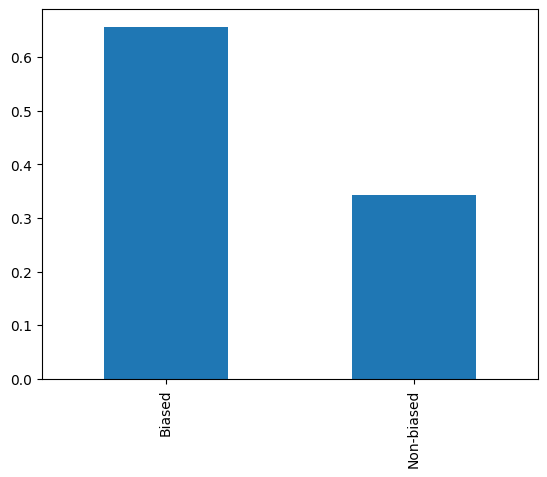

In [ ]:
labeled_df['topic'].value_counts(normalize=True).plot(kind="barh",figsize=(10, 6), sort_columns=True)

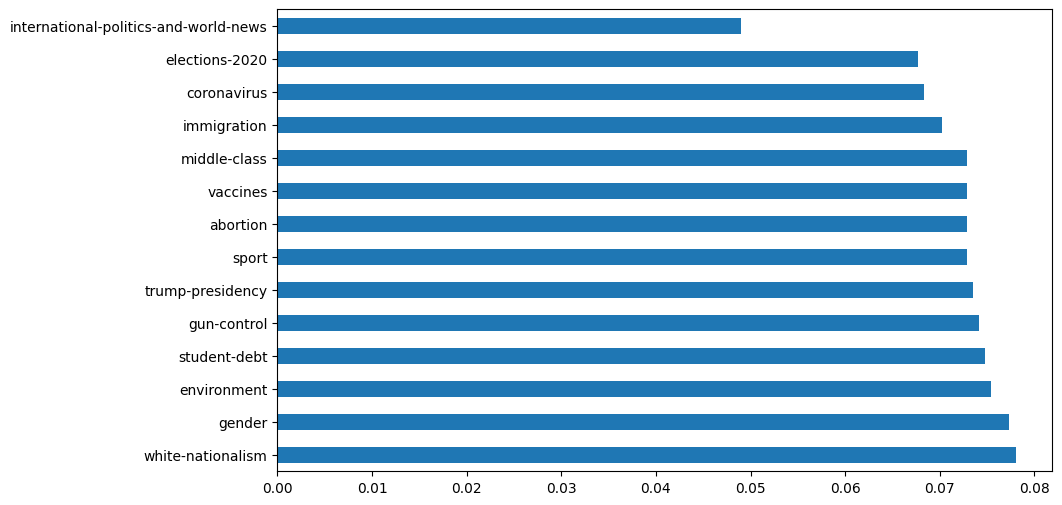

In [ ]:
for i in range(len(labeled_df)):
  if labeled_df['Label_bias'][i] == "Biased":
    labeled_df['Label_bias'][i] = 1
  else:
    labeled_df['Label_bias'][i] = 0
# labeled_df[labeled_df['Label_bias']=="Biased"]['Label_bias'] = 1
# labeled_df[labeled_df['Label_bias']=="Non-biased"]['Label_bias'] = 0

In [ ]:
!pip install sentence-transformers

In [ ]:
import joblib
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
def embedfromTransformer(text):
  return np.array(model.encode(text))

In [ ]:
lr_model = joblib.load("/content/LR_Adhominem.bin")
lr_model.predict(embedfromTransformer(labeled_df['sentence'][0]).reshape(1, -1))
lr_model = joblib.load("/content/LR_Adhominem.bin")
import xgboost as xgb
loader = xgb.Booster()
loader.load_model("xgb_hasty.model")
svc_model = joblib.load("svc_appeal.bin")

In [ ]:
def adhominems(text):
  return lr_model.predict(embedfromTransformer(text).reshape(1, -1))[0]
def hasty(text):
  return np.round(loader.predict(xgb.DMatrix(embedfromTransformer(text).reshape(1, -1)))).astype('int')[0]
def appeal(text):
  return svc_model.predict(embedfromTransformer(text).reshape(1, -1))[0]

In [ ]:
labeled_df['Adhominem'] = labeled_df['sentence'].apply(adhominems)
labeled_df['Hasty'] = labeled_df['sentence'].apply(hasty)
labeled_df['Appeal'] = labeled_df['sentence'].apply(appeal)

In [ ]:
def tokenize(text):
  return [stemmer.stem(word) for word in word_tokenize(text) if word.isalpha()]

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
def tokenize_real(text, n):
  n_grams = ngrams(tokenizer.tokenize(text), n)
  return [ ' '.join(grams) for grams in n_grams]

In [ ]:
biased_df = labeled_df[labeled_df['Label_bias']==1].sample(500, random_state=42)
biased_df.reset_index(drop=True, inplace=True)
unbiased_df = labeled_df[labeled_df['Label_bias']==0].sample(500, random_state=42)
unbiased_df.reset_index(drop=True, inplace=True)
labeled_df = pd.concat([biased_df, unbiased_df], axis=0, ignore_index=True)
labeled_df = shuffle(labeled_df, random_state=100)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=eng_stopwords, ngram_range=(1, 2), max_features=1000)
from sklearn.utils import shuffle
new_df = shuffle(labeled_df, random_state = 42)
train_df = new_df[:int(len(new_df)*0.9)]
test_df = new_df[int(len(new_df)*0.9):]
vectorizer.fit(train_df.sentence.values)
train_inputs = vectorizer.transform(train_df.sentence)
test_inputs = vectorizer.transform(test_df.sentence)

In [ ]:
for i in range(len(train_df)):
  train_df['TF-IDF'][i] = sum(train_inputs.toarray()[i])/len(tokenize(train_df['sentence'][i]))

for i in range(len(test_df)):
  test_df['TF-IDF'][i] = sum(test_inputs.toarray()[i])/len(tokenize(test_df['sentence'][i]))

In [ ]:
## Only taking 1 type of readability
del train_df['Readability Index (Flesch Kincaid)']
del test_df['Readability Index (Flesch Kincaid)']

In [ ]:
# Trying different features
train1 = train_df.iloc[:, 20:22]
train2 = train_df.iloc[:, 25:33]
train3 = train_df.iloc[:, 37:]

test1 = test_df.iloc[:, 20:22]
test2 = test_df.iloc[:, 25:33]
test3 = test_df.iloc[:, 37:]

trainc = pd.concat([train1, train2, train3], axis=1)
testc = pd.concat([test1, test2, test3], axis=1)

train_in = train_df.iloc[:, 22:25]
train_out = train_df.iloc[:, 14].astype('int')
test_in = test_df.iloc[:, 22:25]
test_out = test_df.iloc[:, 14].astype('int')

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
sc = StandardScaler()
sc.fit(train_in.iloc[:, :])
train_in = sc.transform(train_in.iloc[:, :])
train_in
test_in = sc.transform(test_in.iloc[:,:])
test_in

In [ ]:
from sklearn.decomposition import PCA
features = ['GA',	'SA',	'LM',	'Sub',	'SM', 'HM', 'KM',	'WC', 'SF',	'QM',	'FK',	'GF',	'DPL', 'SI', 'CS', 'PS', 'PR', 'YK', 'TF']
unbiased = raw1[raw1['Label_bias']==0].drop('Label_bias', axis = 1)
biased = raw1[raw1['Label_bias']==1].drop('Label_bias', axis=1)

In [ ]:
pcafeab = PCA(n_components=1)
pcafeab.fit(np.array(biased))
# pcafeab.components_, pcafeab.explained_variance_ratio_
# np.max(np.maximum(pcafeab.components_[0], pcafeab.components_[1]))
pca_biased = np.square(pcafeab.components_[0])

In [ ]:
pcafeaub = PCA(n_components=1)
pcafeaub.fit(np.array(unbiased))
pca_unbiased = np.square(pcafeaub.components_[0])

In [ ]:
import matplotlib.pyplot as plt
plt.bar(features, pca_biased)

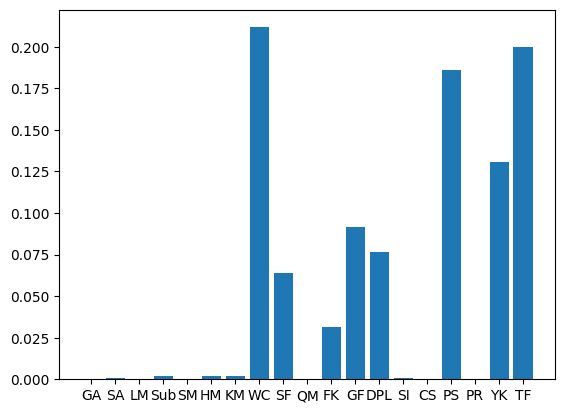

In [ ]:
plt.bar(features, pca_unbiased)

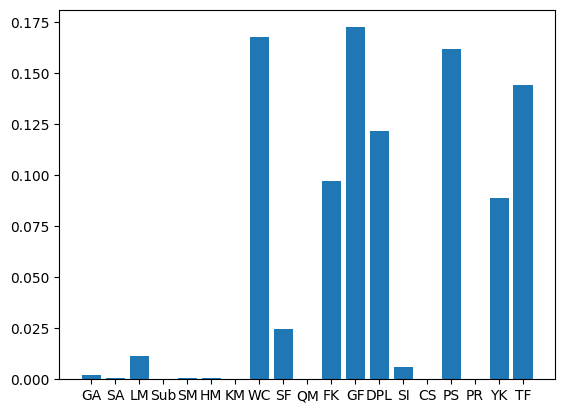

In [ ]:
feature_values = {
    'Biased_Class' : list(pca_biased),
    'Unbiased_Class' : list(pca_unbiased),
}

In [ ]:
x = np.arange(len(features))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in feature_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=5)
    multiplier += 1

ax.set_ylabel("Feature Attributes")
ax.set_title("Target Based Feature attributes for Sentence Dataset")
ax.set_xticks(x+width/2, features)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 0.3)

plt.show()

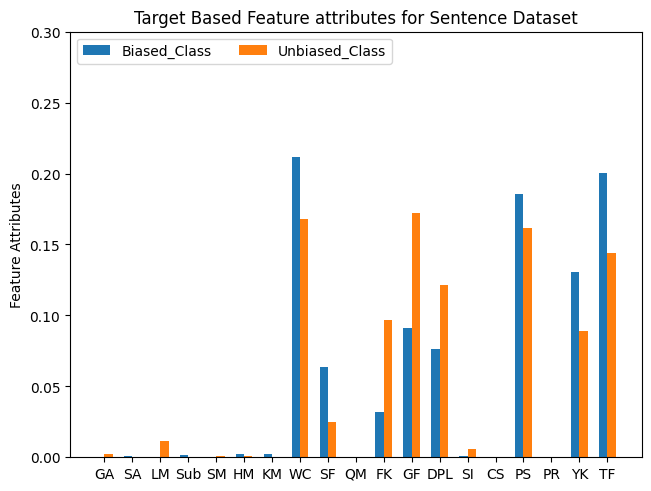

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, make_scorer

In [ ]:
k=5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average='micro')

In [ ]:
model_LR = LogisticRegression(random_state=42)
model_LR.fit(train_in, train_out)
y_pred = cross_val_predict(model_LR, test_in, test_out, cv=kfold)
scores = cross_val_score(model_LR, test_in, test_out, cv=kfold, scoring=scorer)
f1_scores = f1_score(test_out, y_pred, average=None)
print("Cross-validation micro F1 scores:", scores)
print("Mean micro F1 score:", scores.mean())
for class_idx, class_score in enumerate(f1_scores):
    print(f"Class {class_idx}: F1 scores - {class_score}")

In [ ]:
model_RF = RandomForestClassifier(n_estimators=150, random_state=42)
model_RF.fit(train_in, train_out)
y_pred = cross_val_predict(model_RF, test_in, test_out, cv=kfold)
scores = cross_val_score(model_RF, test_in, test_out, cv=kfold, scoring=scorer)
f1_scores = f1_score(test_out, y_pred, average=None)
print("Cross-validation micro F1 scores:", scores)
print("Mean micro F1 score:", scores.mean())
for class_idx, class_score in enumerate(f1_scores):
    print(f"Class {class_idx}: F1 scores - {class_score}")

In [ ]:
model_svc = SVC(kernel='rbf', random_state=42, probability=True)
model_svc.fit(train_in, train_out)
y_pred = cross_val_predict(model_svc, test_in, test_out, cv=kfold)
scores = cross_val_score(model_svc, test_in, test_out, cv=kfold, scoring=scorer)
f1_scores = f1_score(test_out, y_pred, average=None)
print("Cross-validation micro F1 scores:", scores)
print("Mean micro F1 score:", scores.mean())
for class_idx, class_score in enumerate(f1_scores):
    print(f"Class {class_idx}: F1 scores - {class_score}")

In [ ]:
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(train_in, train_out)
y_pred = cross_val_predict(model_xgb, test_in, test_out, cv=kfold)
scores = cross_val_score(model_xgb, test_in, test_out, cv=kfold, scoring=scorer)
f1_scores = f1_score(test_out, y_pred, average=None)
print("Cross-validation micro F1 scores:", scores)
print("Mean micro F1 score:", scores.mean())
for class_idx, class_score in enumerate(f1_scores):
    print(f"Class {class_idx}: F1 scores - {class_score}")

In [ ]:
!pip install shap

In [ ]:
import shap
explainer = shap.Explainer(model_svc.predict_proba, test_in)
shap_values = explainer(test_in)

In [ ]:
import random
random_indices = random.sample(range(156), 10)

In [ ]:
shap.plots.bar(shap_values[:,:,1], max_display=18) # For Biased class
# shap.plots.bar(shap_values[:,:,0], max_display=18) # For Unbiased class

In [ ]:
for x in random_indices:
    shap.plots.waterfall(shap_values[x], max_display=20)

In [ ]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=20)

In [ ]:
shap.plots.waterfall(shap_values[0][:,1], max_display = 20)